<a href="https://colab.research.google.com/github/romax2/MyNotebooks/blob/main/Column_NLI_Model_Final_Multi_Domain_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Project Template
By Mario Ramirez<br>
*Revised on June 3, 2021

# 1. Setup

Check env device, connect to gdrive, installing transformers and importing libraries

In [2]:
#! mkdir './data/'
#! mkdir './models/'
#! ls -l
#from google.colab import files
#uploaded = files.upload()
# source_folder = './data'
# destination_folder = './models'
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#!pip install transformers --quiet
!pip install transformers --quiet

     |████████████████████████████████| 2.5MB 30.6MB/s 
     |████████████████████████████████| 3.3MB 33.0MB/s 
     |████████████████████████████████| 901kB 38.0MB/s 


In [4]:
!pip install umap-learn --quiet

     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 16.4MB/s 


In [5]:
#!pip install hdbscan --quiet

In [6]:
#!pip install sentence-transformers --quiet

In [7]:
# Libraries
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
# Preliminaries
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
# Training
import torch.optim as optim
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

import umap

In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading and setting up Dataset


In [14]:
source_folder = 'gdrive/MyDrive/data/'
destination_folder = 'gdrive/MyDrive/models/'
raw_data = pd.read_csv(source_folder+"clean_data/columnBased-preprocessed-pub.csv")
#raw_data.head()
raw_data.shape

(13041, 17)

In [15]:
dfg = raw_data.groupby(['collectionName'])['collectionName'].count()
print(dfg)
#dfg.plot(kind='bar', title='Data domains/collections', ylabel='Count', xlabel='dataset split', figsize=(6, 5))

collectionName
calderdalebusinessdata     831
foodhygiene               5422
salaries                  6788
Name: collectionName, dtype: int64


#PerPublisher

In [22]:
def clean_data(data, cols):
  for col_name in cols:
    data[col_name] = data[col_name].apply(lambda v: re.sub(r"[\-,.;@#?!&$\)\(]+\ *", " ", v.lower()))

def split_data_func(data, collection_name):
  data['data_type'] = ['train']*data.shape[0]
  data.loc[data['collectionName'] == collection_name, 'data_type'] = 'val'
  
def print_data_summary(data):
  dfg = data.groupby(['data_type'])['data_type'].count()
  print(dfg)


def split_data_by_publisher(data, publisher):
  data['data_type'] = ['train']*data.shape[0]
  data.loc[data['candidatePublisher'] == publisher, 'data_type'] = 'val'

In [25]:
perPublisher=True

if perPublisher==True:
  raw_data = raw_data[raw_data.collectionName == "salaries"]
  dfg = raw_data.groupby(['collectionName'])['collectionName'].count()
  print(dfg)
  dfg = raw_data.groupby(['candidatePublisher'])['candidatePublisher'].count()
  print(dfg)
  split_data_by_publisher(raw_data, 'Cabinet Office')
  #split_data_by_publisher(raw_data, 'Ministry of Defence')
  #split_data_by_publisher(raw_data, 'Department for Business, Innovation and Skills')
  #split_data_by_publisher(raw_data, 'UK Statistics Authority')
else:
  split_data_func(raw_data, 'salaries')
  #split_data_func(raw_data, 'calderdalebusinessdata')
  #split_data_func(raw_data, 'foodhygiene')

collectionName
salaries    6788
Name: collectionName, dtype: int64
candidatePublisher
Cabinet Office                                    2028
Department for Business, Innovation and Skills     297
Ministry of Defence                                803
UK Statistics Authority                            292
Name: candidatePublisher, dtype: int64


In [26]:
print_data_summary(raw_data)
raw_data.head()




data_type
train    4760
val      2028
Name: data_type, dtype: int64


,collectionName,gtKey,targetPublisher,target_ds,targetAttPrefix,targetKey,xt1,xt2,xt3,candidatePublisher,candidate_ds,candidateAttPrefix,candidateKey,yt1,yt2,yt3,value,data_type
0,salaries,0G81FDQ_clxhxmv--0JUSLET_cpdoycs,NaN,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,NaN,0JUSLET,cpdoycs,0JUSLET_cpdoycs,Payscale Minimum is property of 150930 Organog...,Payscale Minimum is property of 150930 Organog...,Payscale Minimum is property of 150930 Organog...,IND,train
1,salaries,0G81FDQ_clxhxmv--0JUSLET_jfcykcm,NaN,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,NaN,0JUSLET,jfcykcm,0JUSLET_jfcykcm,Parent Department is property of 150930 Organo...,Parent Department is property of 150930 Organo...,Parent Department is property of 150930 Organo...,IND,train
2,salaries,0G81FDQ_clxhxmv--0JUSLET_jnmpagp,NaN,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,NaN,0JUSLET,jnmpagp,0JUSLET_jnmpagp,Organisation is property of 150930 Organogram ...,Organisation is property of 150930 Organogram ...,Organisation is property of 150930 Organogram ...,ALT,train
3,salaries,0G81FDQ_clxhxmv--0JUSLET_liuxawt,NaN,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,NaN,0JUSLET,liuxawt,0JUSLET_liuxawt,Reporting Senior Post is property of 150930 Or...,Reporting Senior Post is property of 150930 Or...,Reporting Senior Post is property of 150930 Or...,IND,train
4,salaries,0G81FDQ_clxhxmv--0JUSLET_mccsbjf,NaN,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,Organisation is property of her majestys reven...,NaN,0JUSLET,mccsbjf,0JUSLET_mccsbjf,Grade is property of 150930 Organogram Data Ho...,Grade is property of 150930 Organogram Data Ho...,Grade is property of 150930 Organogram Data Ho...,IND,train


In [74]:
clean_data(raw_data, ['xt1','xt2','xt3','yt1','yt2','yt3',])
raw_data.head()

,collectionName,gtKey,target_ds,targetAttPrefix,targetKey,xt1,xt2,xt3,candidate_ds,candidateAttPrefix,candidateKey,yt1,yt2,yt3,value,data_type
0,salaries,0G81FDQ_clxhxmv--0JUSLET_cpdoycs,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,cpdoycs,0JUSLET_cpdoycs,payscale minimum is property of 150930 organog...,payscale minimum is property of 150930 organog...,payscale minimum is property of 150930 organog...,IND,train
1,salaries,0G81FDQ_clxhxmv--0JUSLET_jfcykcm,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,jfcykcm,0JUSLET_jfcykcm,parent department is property of 150930 organo...,parent department is property of 150930 organo...,parent department is property of 150930 organo...,IND,train
2,salaries,0G81FDQ_clxhxmv--0JUSLET_jnmpagp,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,jnmpagp,0JUSLET_jnmpagp,organisation is property of 150930 organogram ...,organisation is property of 150930 organogram ...,organisation is property of 150930 organogram ...,ALT,train
3,salaries,0G81FDQ_clxhxmv--0JUSLET_liuxawt,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,liuxawt,0JUSLET_liuxawt,reporting senior post is property of 150930 or...,reporting senior post is property of 150930 or...,reporting senior post is property of 150930 or...,IND,train
4,salaries,0G81FDQ_clxhxmv--0JUSLET_mccsbjf,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,mccsbjf,0JUSLET_mccsbjf,grade is property of 150930 organogram data ho...,grade is property of 150930 organogram data ho...,grade is property of 150930 organogram data ho...,IND,train


,collectionName,gtKey,target_ds,targetAttPrefix,targetKey,xt1,xt2,xt3,candidate_ds,candidateAttPrefix,candidateKey,yt1,yt2,yt3,value,data_type
0,salaries,0G81FDQ_clxhxmv--0JUSLET_cpdoycs,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,cpdoycs,0JUSLET_cpdoycs,payscale minimum is property of 150930 organog...,payscale minimum is property of 150930 organog...,payscale minimum is property of 150930 organog...,IND,train
1,salaries,0G81FDQ_clxhxmv--0JUSLET_jfcykcm,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,jfcykcm,0JUSLET_jfcykcm,parent department is property of 150930 organo...,parent department is property of 150930 organo...,parent department is property of 150930 organo...,IND,train
2,salaries,0G81FDQ_clxhxmv--0JUSLET_jnmpagp,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,jnmpagp,0JUSLET_jnmpagp,organisation is property of 150930 organogram ...,organisation is property of 150930 organogram ...,organisation is property of 150930 organogram ...,ALT,train
3,salaries,0G81FDQ_clxhxmv--0JUSLET_liuxawt,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,liuxawt,0JUSLET_liuxawt,reporting senior post is property of 150930 or...,reporting senior post is property of 150930 or...,reporting senior post is property of 150930 or...,IND,train
4,salaries,0G81FDQ_clxhxmv--0JUSLET_mccsbjf,0G81FDQ,clxhxmv,0G81FDQ_clxhxmv,organisation is property of her majestys reven...,organisation is property of her majestys reven...,organisation is property of her majestys reven...,0JUSLET,mccsbjf,0JUSLET_mccsbjf,grade is property of 150930 organogram data ho...,grade is property of 150930 organogram data ho...,grade is property of 150930 organogram data ho...,IND,train


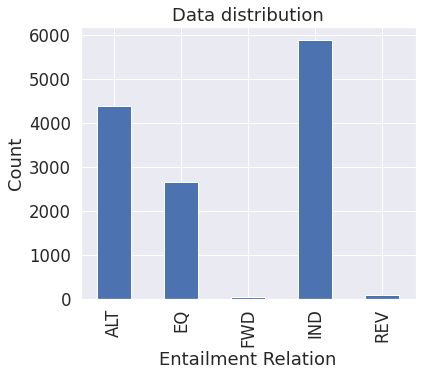

In [75]:
dfg = raw_data.groupby(['value'])['value'].count()
dfg.plot(kind='bar', title='Data distribution', ylabel='Count', xlabel='Entailment Relation', figsize=(6, 5))
raw_data.head()

## 2.2. Parse

Clean up descriptors in dataset, remove unwanted columns from dataframe.

Spliting into training and validation sets

In [76]:
#DATA SPLIT
label_dict = {label: i for i, label in enumerate(raw_data.value.unique())}
print(label_dict)

#BEFORE
#raw_data['data_type'] = ['not_set']*raw_data.shape[0]
#raw_data.loc[X_train, 'data_type'] = 'train'
#raw_data.loc[X_val, 'data_type'] = 'val'

#AFTER
#raw_data['data_type'] = ['not_set']*raw_data.shape[0]

raw_data['label'] = raw_data.value.replace(label_dict)
raw_data.groupby(['value', 'data_type']).count()

{'IND': 0, 'ALT': 1, 'EQ': 2, 'REV': 3, 'FWD': 4}


collectionName  gtKey  target_ds  ...   yt2   yt3  label
value data_type                                    ...                   
ALT   train                4335   4335       4335  ...  4335  4335   4335
      val                    44     44         44  ...    44    44     44
EQ    train                2623   2623       2623  ...  2623  2623   2623
      val                    35     35         35  ...    35    35     35
FWD   train                   8      8          8  ...     8     8      8
      val                    26     26         26  ...    26    26     26
IND   train                 583    583        583  ...   583   583    583
      val                  5300   5300       5300  ...  5300  5300   5300
REV   train                  70     70         70  ...    70    70     70
      val                    17     17         17  ...    17    17     17

[10 rows x 15 columns]



Let's extract the sentences and labels of our training set as numpy ndarrays.

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

In [77]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [78]:
# Get the lists of sentences and their labels.
txsentences = raw_data.xt3.values
tysentences = raw_data.yt3.values
#labels = df.label.values
print(' Original: ', txsentences[0])
print('Tokenized: ', tokenizer.tokenize(txsentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(txsentences[0])))




 Original:  organisation is property of her majestys revenue and customs 30 09 2011 hmrc 300911 hmrc organogram final junior and is related to parent department and unit and has values her majesty's revenue and customs
Tokenized:  ['organisation', 'is', 'property', 'of', 'her', 'majesty', '##s', 'revenue', 'and', 'customs', '30', '09', '2011', 'hm', '##rc', '300', '##9', '##11', 'hm', '##rc', 'organ', '##og', '##ram', 'final', 'junior', 'and', 'is', 'related', 'to', 'parent', 'department', 'and', 'unit', 'and', 'has', 'values', 'her', 'majesty', "'", 's', 'revenue', 'and', 'customs']
Token IDs:  [5502, 2003, 3200, 1997, 2014, 9995, 2015, 6599, 1998, 8205, 2382, 5641, 2249, 20287, 11890, 3998, 2683, 14526, 20287, 11890, 5812, 8649, 6444, 2345, 3502, 1998, 2003, 3141, 2000, 6687, 2533, 1998, 3131, 1998, 2038, 5300, 2014, 9995, 1005, 1055, 6599, 1998, 8205]


In [79]:
max_l = 0

for sent in txsentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True) # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    max_l = max(max_l, len(input_ids))    # Update the maximum sentence length.

for sent in tysentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_l = max(max_l, len(input_ids))

print('Max sentence length: ', max_l)

Max sentence length:  229


Tokenizing all dataset will:
  (1) Tokenize the sentence.<br>
  (2) Prepend the `[CLS]` token to the start.<br>
  (3) Append the `[SEP]` token to the end.<br>
  (4) Map tokens to their IDs.<br>
  (5) Pad or truncate the sentence to `max_length`<br>
  (6) Create attention masks for [PAD] tokens.<br>

In [80]:
max_len = 256
#max_len = 128
encoded_data_train = tokenizer.batch_encode_plus(zip(raw_data[raw_data.data_type=='train'].xt3.values.tolist(), raw_data[raw_data.data_type=='train'].yt3.values.tolist()), 
                                                 is_split_into_words=False, 
                                                 padding=True,
                                                 add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                                                 return_attention_mask=True,# Construct attn. masks.
                                                 max_length=max_len,# Pad & truncate all sentences.
                                                 return_tensors='pt')# Return pytorch tensors.
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(raw_data[raw_data.data_type=='train'].label.values)

encoded_data_val = tokenizer.batch_encode_plus(zip(raw_data[raw_data.data_type=='val'].xt3.values.tolist(), raw_data[raw_data.data_type=='val'].yt3.values.tolist()),
                                               is_split_into_words=False, 
                                               padding=True,
                                               add_special_tokens=True,
                                               return_attention_mask=True,
                                               max_length=max_len,
                                               return_tensors='pt')
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(raw_data[raw_data.data_type=='val'].label.values)

Visual Characterization

In [81]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(7619, 5422)

Create dataset iterator by using torch DataLoader class. This avoids loading the dataset into memory, which is memory efficient.

In [82]:
BATCH_SIZE = 3 #DataLoader needs to know this (BERT recomendation is 16 or 32)
#BATCH_SIZE = 16 #DataLoader needs to know this (BERT recomendation is 16 or 32)

dataloader_train = DataLoader(dataset_train, #training samples
                              sampler=RandomSampler(dataset_train), #select batches randomly
                              batch_size=BATCH_SIZE)#train with this batch size
dataloader_validation = DataLoader(dataset_val, #validation samples
                                   sampler=SequentialSampler(dataset_val), #take batches sequentially
                                   batch_size=BATCH_SIZE)# evaluate using this batch size

# 4. Set up Classification Model

Configuring model...

In [83]:
EPOCHS = 5
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  #Use 12-layer BERT model, with uncased vocab.
                                                      num_labels=len(label_dict), #number of output labels
                                                      output_attentions=False, #Whether model returns attentions weights
                                                      output_hidden_states=False)#Whether the model returns all hidden-states

#Weight Decay fix
optimizer = AdamW(model.parameters(), 
                  lr=1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8)# args.adam_epsilon  - default is 1e-8.

#learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*EPOCHS)

model.cuda()                                                      

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [84]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.1. Define Model

In [85]:
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
  label_dict_inverse = {v: k for k, v in label_dict.items()}  
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}' + ', ' + str(len(y_preds[y_preds==label])/len(y_true)) + '\n')

def evaluate(model, dataloader_val, device):
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []
    
  for batch in dataloader_val:   
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
              }
    with torch.no_grad():
      outputs = model(**inputs)
      
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
    
  loss_val_avg = loss_val_total/len(dataloader_val)   
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
            
  return loss_val_avg, predictions, true_vals

def single_eval():
  print("single eval")

def train(model, epochs,dataloader_train, dataloader_validation, optimizer, scheduler, device='cpu'):
  model = model.to(device)
  model.train()
  for epoch in tqdm(range(1, epochs+1)):
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
      model.zero_grad()
      batch = tuple(b.to(device) for b in batch)
      inputs = {'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
                }       
      outputs = model(**inputs)
        
      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()
        
      progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model.state_dict(), f'./models/finetuned_BERT_epoch_{epoch}.model')   
    torch.save(model.state_dict(), f'gdrive/MyDrive/models/finetuned_BERT_epoch_{epoch}.model')   

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, dataloader_validation, device=device)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

## 4.2. Verbose Model

In [86]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_verbose_model(model, epochs,dataloader_train, dataloader_validation, optimizer, scheduler, device='cpu'):
  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(dataloader_train):

          # Progress update every 40 batches.
          #if step % 40 == 0 and not step == 0:
          if step % 200 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader_train), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward` 
          # function and pass down the arguments. The `forward` function is 
          # documented here: 
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(dataloader_train)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in dataloader_validation:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the 
          # output values prior to applying an activation function like the 
          # softmax.
          loss = result.loss
          logits = result.logits
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(dataloader_validation)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(dataloader_validation)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return training_stats

## 4.3. Execute Model

In [87]:
seed_val = 17#42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)    

#train(model, EPOCHS, dataloader_train, dataloader_validation, optimizer, scheduler, device=DEVICE)
my_stats = train_verbose_model(model, EPOCHS, dataloader_train, dataloader_validation, optimizer, scheduler, device=DEVICE)


======== Epoch 1 / 5 ========
Training...
  Batch   200  of  2,540.    Elapsed: 0:01:57.
  Batch   400  of  2,540.    Elapsed: 0:03:52.
  Batch   600  of  2,540.    Elapsed: 0:05:48.
  Batch   800  of  2,540.    Elapsed: 0:07:43.
  Batch 1,000  of  2,540.    Elapsed: 0:09:39.
  Batch 1,200  of  2,540.    Elapsed: 0:11:34.
  Batch 1,400  of  2,540.    Elapsed: 0:13:29.
  Batch 1,600  of  2,540.    Elapsed: 0:15:25.
  Batch 1,800  of  2,540.    Elapsed: 0:17:20.
  Batch 2,000  of  2,540.    Elapsed: 0:19:15.
  Batch 2,200  of  2,540.    Elapsed: 0:21:10.
  Batch 2,400  of  2,540.    Elapsed: 0:23:06.

  Average training loss: 0.13
  Training epcoh took: 0:24:26

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.29
  Validation took: 0:02:24

======== Epoch 2 / 5 ========
Training...
  Batch   200  of  2,540.    Elapsed: 0:01:55.
  Batch   400  of  2,540.    Elapsed: 0:03:51.
  Batch   600  of  2,540.    Elapsed: 0:05:46.
  Batch   800  of  2,540.    Elapsed: 0:07:41.
  Batch 1

## 5. Summary of results

In [88]:
# Display floats with two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=my_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.33e-01,0.29,0.95,0:24:26,0:02:24
2,2.78e-02,0.22,0.95,0:24:23,0:02:24
3,1.31e-02,0.21,0.97,0:24:23,0:02:24
4,6.29e-03,0.26,0.96,0:24:23,0:02:24
5,1.94e-03,0.32,0.96,0:24:23,0:02:24


(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

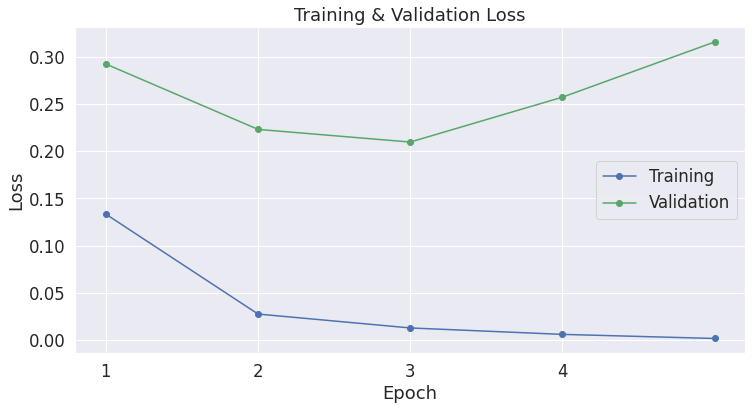

In [89]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##5.1 Summary of metrics

In [90]:
model = model.to(DEVICE)
# _, predictions, true_vals = evaluate(model, dataloader_test, device=DEVICE)
_, predictions, true_vals = evaluate(model, dataloader_validation, device=DEVICE)
accuracy_per_class(predictions, true_vals)

Class: IND
Accuracy: 5152/5300, 0.9720754716981133

Class: ALT
Accuracy: 24/44, 0.5454545454545454

Class: EQ
Accuracy: 3/35, 0.08571428571428572

Class: REV
Accuracy: 0/17, 0.0

Class: FWD
Accuracy: 0/26, 0.0



In [1]:
y_pred = np.argmax(predictions, axis=1)
print(classification_report(true_vals, y_pred, target_names=list(label_dict.keys())))
#print(classification_report(true_vals, y_pred, target_names=["IND","EQ","ALT"]))

NameError: ignored

In [92]:
len(dataset_train), len(dataset_val)

(7619, 5422)

(7619, 5422)